# Make template background model

## Introduction 

In this tutorial, we will create a template background model from scratch. Often, background models are pre-computed and provided for analysis, but it's educational to see how the sausage is made.

We will use the "off observations", i.e. those without significant gamma-ray emission sources in the field of view from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/). This model could then be used in the analysis of sources from that dataset (not done here).

We will make a background model that is radially symmetric in the field of view, i.e. only depends on field of view offset angle and energy. At the end, we will save the model in the `BKG_2D` as defined in the [spec](https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/full_enclosure/bkg/index.html).

Note that this is just a quick and dirty example. Actual background model production is done with more sophistication usually using 100s or 1000s of off runs, e.g. concerning non-radial symmetries, binning and smoothing of the distributions, and treating other dependencies such as zenith angle, telescope configuration or optical efficiency. Another aspect not shown here is how to use AGN observations to make background models, by cutting out the part of the field of view that contains gamma-rays from the AGN.

We will mainly be using the following classes:
        
* [gammapy.data.DataStore](http://docs.gammapy.org/dev/api/gammapy.data.DataStore.html) to load the runs to use to build the bkg model.
* [gammapy.irf.Background2D](http://docs.gammapy.org/dev/api/gammapy.irf.Background2D.html) to represent and write the background model.

## Setup

As always, we start the notebook with some setup and imports.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from copy import deepcopy
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table

In [3]:
from gammapy.extern.pathlib import Path
from gammapy.utils.nddata import sqrt_space
from gammapy.data import DataStore
from gammapy.irf import Background2D

## Select off data

We start by selecting the observations used to estimate the background model.

In this case, we just take all "off runs" as defined in the observation table.

In [4]:
data_store = DataStore.from_dir("../datasets/hess-dl3-dr1")
mask = data_store.obs_table["OBS_SUBSET_TAG"] == "offdata"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
observations = data_store.obs_list(obs_ids)
print("Number of observations:", len(observations))

Number of observations: 45


## Estimate background model

The background model we will estimate is a differential background rate model in unit `s-1 MeV-1 sr-1` as a function of reconstructed energy and field of fiew offset.

We estimate it by histogramming off data events and then smoothing a bit (not using a good method) to get a less noisy estimate. To get the differential rate, we divide by observation time and also take bin sizes into account to get the rate per energy and solid angle. So overall we fill two arrays called `counts` and `exposure` with `exposure` filled so that `background_rate = counts / exposure` will give the final background rate we're interested in.

The processing can be done either one observation at a time, or first for counts and then for exposure. Either way is fine. Here we do one observation at a time, starting with empty histograms and then accumulating counts and exposure. Since this is a multi-step algorithm, we put the code to do this computation in a `BackgroundModelEstimator` class.

This functionality was already in Gammapy previously, and will be added back again soon, after `gammapy.irf` has been restructured and improved.

In [5]:
class BackgroundModelEstimator(object):
    def __init__(self, ebounds, offset):
        self.counts = self._make_bkg2d(ebounds, offset, unit="")
        self.exposure = self._make_bkg2d(ebounds, offset, unit="s MeV sr")

    @staticmethod
    def _make_bkg2d(ebounds, offset, unit):
        ebounds = ebounds.to("MeV")
        offset = offset.to("deg")
        shape = len(ebounds) - 1, len(offset) - 1
        return Background2D(
            energy_lo=ebounds[:-1],
            energy_hi=ebounds[1:],
            offset_lo=offset[:-1],
            offset_hi=offset[1:],
            data=np.zeros(shape) * u.Unit(unit),
        )

    def run(self, observations):
        for obs in observations:
            self.fill_counts(obs)
            self.fill_exposure(obs)

    def fill_counts(self, obs):
        events = obs.events
        data = self.counts.data
        counts = np.histogram2d(
            x=events.energy.to("MeV"),
            y=events.offset.to("deg"),
            bins=(data.axes[0].bins, data.axes[1].bins),
        )[0]
        data.data += counts

    def fill_exposure(self, obs):
        data = self.exposure.data
        energy_width = data.axes[0].bin_width
        offset = data.axes[1].nodes
        offset_width = data.axes[1].bin_width
        solid_angle = 2 * np.pi * offset * offset_width
        time = obs.observation_time_duration
        exposure = time * energy_width[:, None] * solid_angle[None, :]
        data.data += exposure

    @property
    def background_rate(self):
        rate = deepcopy(self.counts)
        rate.data.data /= self.exposure.data.data
        return rate

In [6]:
%%time
ebounds = np.logspace(-1, 2, 20) * u.TeV
offset = sqrt_space(start=0, stop=2.5, num=10) * u.deg
estimator = BackgroundModelEstimator(ebounds, offset)
# observations = observations[:3]  # To run more quickly for debugging
estimator.run(observations)

CPU times: user 2.06 s, sys: 36.5 ms, total: 2.1 s
Wall time: 2.1 s


## Check background model

Let's make a few plots to see what our background model looks like:

1. Acceptance curve (background rate as a function of field of view offset for a given energy)
1. Rate spectrum (background rate as a function of energy for a given offset)
1. Rate image (background rate as a function of energy and offset)

### Acceptance curve

(19, 9)
(20,)
(10,)


Text(0,0.5,'Offset (deg)')

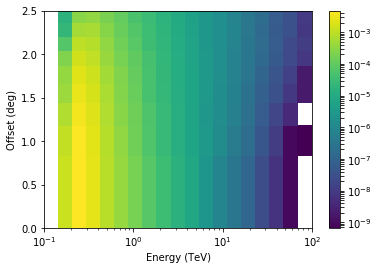

In [7]:
from matplotlib.colors import LogNorm

hist = estimator.background_rate.data.data
print(hist.shape)
print(ebounds.shape)
print(offset.shape)
plt.pcolormesh(ebounds, offset, hist.T.value, norm=LogNorm())
plt.semilogx()
plt.colorbar()
plt.xlabel("Energy (TeV)")
plt.ylabel("Offset (deg)")

In [8]:
# You could save the background model to a file like this
# estimator.background_rate.to_fits().writeto('background_model.fits', overwrite=True)

## TODO

**The rest of the notebook is still the old version.
Needs to be removed or rewritten.**

In [9]:
# Read one of the background models from file
filename = scratch_dir / "smooth_background_2D_group_000_table.fits.gz"
model = EnergyOffsetBackgroundModel.read(str(filename))

NameError: name 'scratch_dir' is not defined

In [ ]:
offset = model.bg_rate.offset_bin_center
energies = model.bg_rate.energy
iE = 6

x = offset
y = model.bg_rate.data[iE, :]
plt.plot(x, y, label="bkg model smooth")
title = (
    "energy band: "
    + str("%.2f" % energies[iE].value)
    + "-"
    + str("%.2f" % energies[iE + 1].value)
    + " TeV"
)
plt.title(title)
plt.xlabel("Offset (degree)")
plt.ylabel("Bkg rate (MeV-1 s-1 sr-1)")
plt.legend()

### Background rate spectrum

In [ ]:
x = energies.log_centers
y = model.bg_rate.data[:, 10]
plt.loglog(x, y, label="bkg model smooth")
plt.title("offset: " + str("%.2f" % offset[10].value) + " deg")
plt.xlabel("Energy (TeV)")
plt.ylabel("Bkg rate (MeV-1 s-1 sr-1)")

### Background rate image with energy and offset axes

It doesn't look good in this case.
To do this well, you need to use more off or AGN runs to build the background model!

In [ ]:
model.bg_rate.plot()

## Make new index table

Here we first copy the dataset of the 4 crab runs from gammapy-extra in a new directory containing the data you will use for the analysis. 

We use the same dataset to produce the bkg or for the analysis. Of course normally you produce the bkg model using thousands of AGN runs not the 4 Crab test runs.

In [ ]:
# Make a new hdu table in your dataset directory that contains the link to the acceptance curve to use to build the bkg model in your cube analysis
data_dir = make_fresh_dir("data")

In [ ]:
ds = DataStore.from_dir("$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2")
ds.copy_obs(ds.obs_table, data_dir)

The hdu_table in this directory contains no link to a bkg model for each observation. 

In [ ]:
data_store = DataStore.from_dir(data_dir)
data_store.hdu_table

In order to produce a background image or background cube we have to create a hdu table that contains for each observation a link to the bkg model to use depending of the observation conditions of the run.

In [ ]:
# Copy the background directory in the one where is located the hdu table, here data
shutil.move(str(scratch_dir), str(data_dir))

# Create the new hdu table with a link to the background model
group_filename = data_dir / "background/group-def.fits"

# relat_path= (scratch_dir.absolute()).relative_to(data_dir.absolute())
hdu_index_table = bgmaker.make_total_index_table(
    data_store=data_store,
    modeltype="2D",
    out_dir_background_model=scratch_dir,
    filename_obs_group_table=str(group_filename),
    smooth=False,
)

# Write the new hdu table
filename = data_dir / "hdu-index.fits.gz"
hdu_index_table.write(str(filename), overwrite=True)

In [ ]:
hdu_index_table

In [ ]:
print(hdu_index_table[-4]["FILE_DIR"], " ", hdu_index_table[-4]["FILE_NAME"])

In [ ]:
print(hdu_index_table[-1]["FILE_DIR"], " ", hdu_index_table[-1]["FILE_NAME"])

## Exercises

- Use real AGN run
- Change the binning for the grouping: thinner zenithal bin, add efficiency binning ....
- Change the energy binning (ebounds) and the offset (offset) used to compute the acceptance curve


## What next?

In this tutorial we have created a template background model in the `bkg_2d` format, i.e. with offset and energy axes (see [spec](http://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/background/index.html#bkg-2d-format)).

In future tutorials, we will use this background model as one of the model components for source analysis.